In [133]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import shap

from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

import seaborn as sns

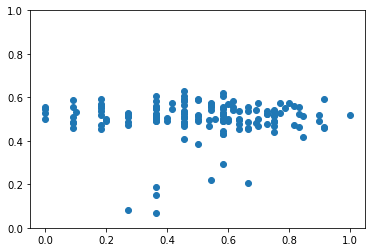

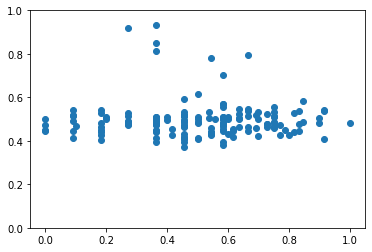

In [ ]:
YEAR = 2007
year_df = df[df['YEAR'] == YEAR]

plt.scatter(year_df['WIN_RATE'].values, year_df['UGDS_WOMEN'].values)
plt.ylim(0, 1)
plt.show()
plt.scatter(year_df['WIN_RATE'].values, year_df['UGDS_MEN'].values)
plt.ylim(0, 1)
plt.show()

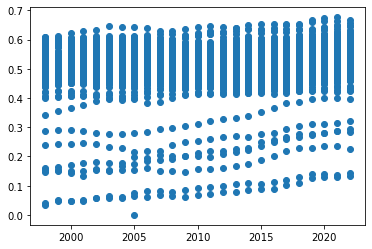

In [ ]:
plt.scatter(df['YEAR'].values, df[''].values)

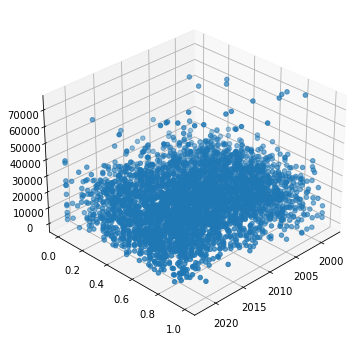

In [102]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['YEAR'].values, df['WIN_RATE'].values, df['UGDS'].values)
ax.view_init(elev=30, azim=45)

In [189]:
def optimal_model(X, y, title, features=None, do_shap=False):
    # create train test split and apply Standard Scaler
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    X_train = X_train.astype(float)
    X_test = X_test.astype(float)
    y_train = y_train.astype(float)
    y_test = y_test.astype(float)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # intialize model and parameters
    xgb_tree = XGBRegressor()

    param_grid = {
        'alpha' : [0.01, 0.1, 1.],
        'gamma' : [0.01, 0.1, 1.],
        'lambda' : [0.01, 0.1, 1.],
        'eta' : [0.1, 0.2, 0.3, 0.4]
    }

    # perform grid search
    xgb_grid_search = GridSearchCV(xgb_tree, param_grid, scoring="neg_mean_squared_error", n_jobs=-1)
    xgb_grid_search.fit(X_train, y_train)
    print(title)
    print()

    # evaluate and print results
    best_xgb = xgb_grid_search.best_estimator_
    print(xgb_grid_search.best_params_)
    print(f"Best MSE: {-1 * xgb_grid_search.best_score_}")
    y_pred = best_xgb.predict(X_test)
    print(f"R^2 Score: {r2_score(y_test, y_pred)}")

    if features is not None:
        # print and plot feature analysis
        best_xgb = xgb_grid_search.best_estimator_

        feature_importance = best_xgb.feature_importances_
        index = np.argsort(feature_importance)[::-1]
        top3 = index[:3]
        print("Most important features: ", np.array(features)[top3])

        plt.barh(features, feature_importance)
        plt.suptitle(title)
        plt.title("Feature Importance")
        plt.show()
    
    if do_shap:
        explainer = shap.Explainer(best_xgb, X_train)
        shap_values = explainer(X_test)

        win_index = features.index('WIN_RATE')

        plt.figure()
        shap.summary_plot(shap_values, X_test, feature_names=features)

        win_rates = X_test[:, win_index]
        shap_win_values = shap_values.values[:, win_index]

        x_vals = np.linspace(np.min(win_rates)-.1, np.max(win_rates)+.1, 50)
        slope, intercept = np.polyfit(win_rates, shap_win_values, 1)

        # plt.figure()
        # shap.dependence_plot(
        #     ind=win_index,
        #     shap_values = shap_values.values,
        #     features=X_test,
        #     feature_names=features,
        # )
        plt.figure()
        plt.scatter(win_rates, shap_win_values, c=y_test, cmap='bwr', alpha=0.75, s=4)
        plt.plot(x_vals, slope * x_vals + intercept, 'k')
        plt.colorbar(label=f"Value of {title}")
        plt.xlabel('Win Rate (Adjusted)')
        plt.ylabel(f'Contribution of Win Rate to {title}')
        plt.title(f"Interaction Between Win Rate and {title}")
        plt.show()

        # plt.figure()
        # shap.dependence_plot(index[0], shap_values.values, X_test, feature_names=features)


In [185]:
def feature_importance(TARGET):
    df = pd.read_csv("football_admission_cleaned.csv") 

    teams = df["TEAM"].unique().tolist()
    # print(teams)
    cols = df.columns.tolist()
    # print(cols)

    targets = ['ADM_RATE', 'UGDS', 'ACTCMMID', 'SAT_AVG', 'UGDS_WHITE', 'UGDS_BLACK', 'UGDS_HISP', 'UGDS_ASIAN', 'UGDS_MEN', 'UGDS_WOMEN']
    y = df[TARGET].values
    df.drop(columns=targets, inplace=True)
    df.drop(columns=['TEAM', 'INSTNM', 'YEAR'], inplace=True)
    df.drop(columns=['WON', 'LOST', 'TIED'], inplace=True)
    X = df.values

    cols = df.columns.tolist()

    optimal_model(X, y, TARGET, cols, do_shap=True)

UGDS_WHITE

{'alpha': 0.1, 'eta': 0.1, 'gamma': 0.01, 'lambda': 0.01}
Best MSE: 0.02948405549913401
R^2 Score: 0.7586916648660591
Most important features:  ['ON_CAMPUS_EXPENSES' 'REGION' 'TUITIONFEE_IN']


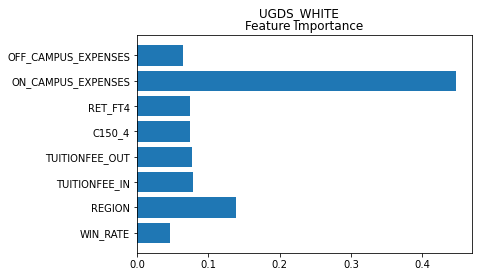

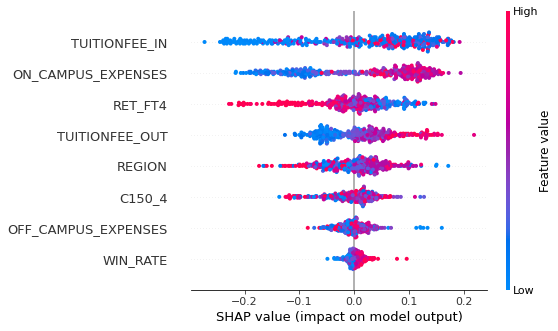

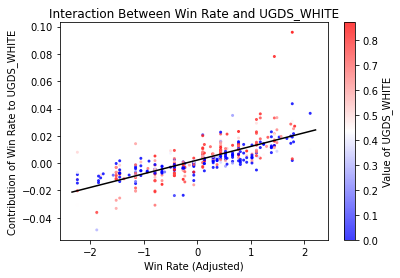

UGDS_BLACK

{'alpha': 0.01, 'eta': 0.1, 'gamma': 0.01, 'lambda': 0.1}
Best MSE: 0.0013761797571132015
R^2 Score: 0.7499904510356306
Most important features:  ['OFF_CAMPUS_EXPENSES' 'REGION' 'C150_4']


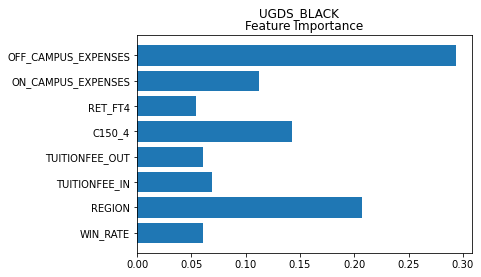

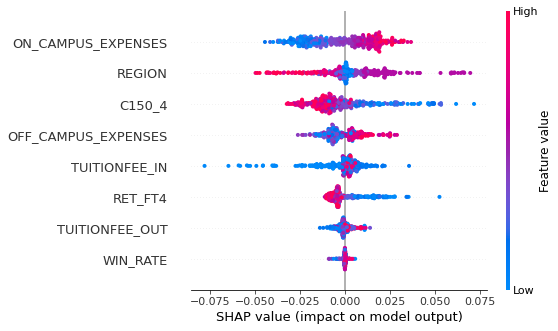

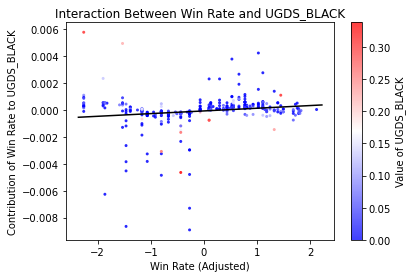

UGDS_HISP

{'alpha': 0.01, 'eta': 0.1, 'gamma': 0.01, 'lambda': 0.01}
Best MSE: 0.0017694714786915706
R^2 Score: 0.8264898777268815
Most important features:  ['REGION' 'ON_CAMPUS_EXPENSES' 'C150_4']


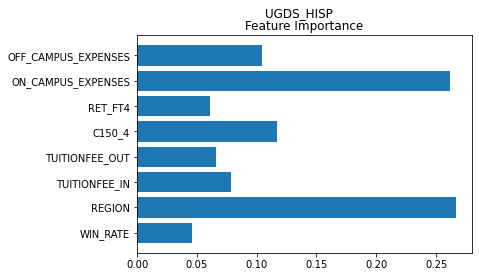

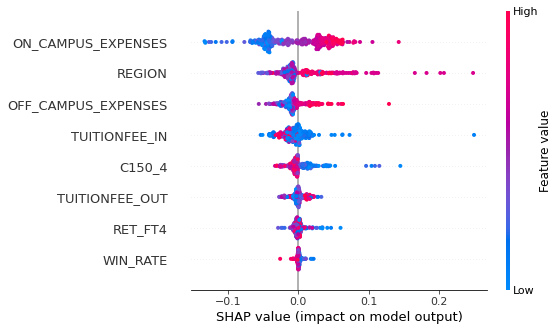

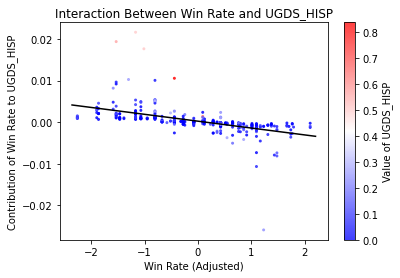

UGDS_ASIAN

{'alpha': 0.01, 'eta': 0.1, 'gamma': 0.01, 'lambda': 1.0}
Best MSE: 0.0012120334474826496
R^2 Score: 0.8378978038308844
Most important features:  ['ON_CAMPUS_EXPENSES' 'RET_FT4' 'REGION']


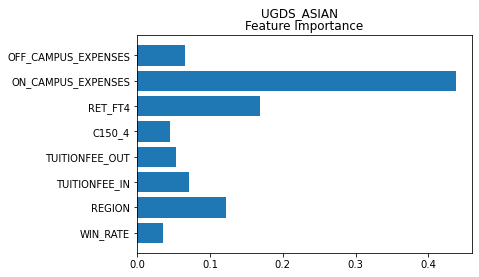

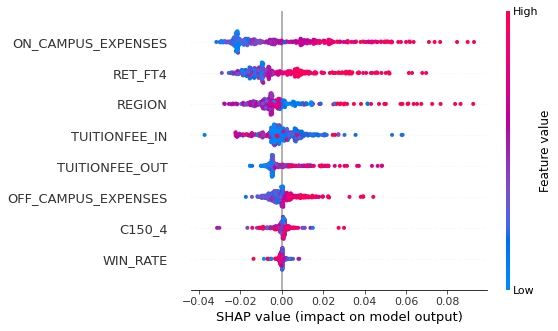

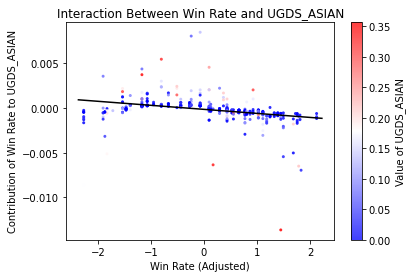

UGDS_MEN

{'alpha': 0.01, 'eta': 0.4, 'gamma': 0.01, 'lambda': 0.1}
Best MSE: 0.0019630275127028047
R^2 Score: 0.7691841309002404
Most important features:  ['OFF_CAMPUS_EXPENSES' 'RET_FT4' 'C150_4']


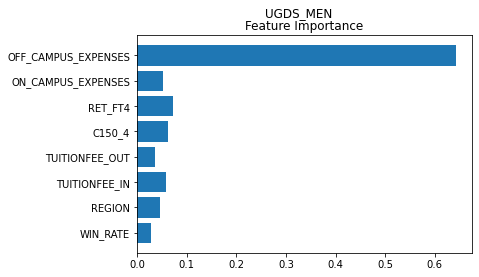

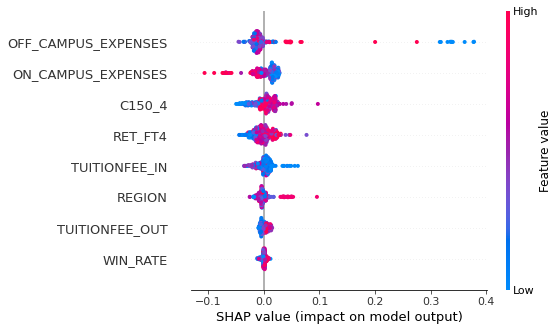

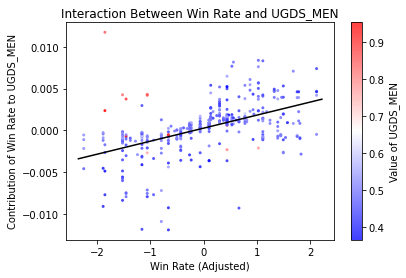

UGDS_WOMEN

{'alpha': 0.01, 'eta': 0.3, 'gamma': 0.01, 'lambda': 0.1}
Best MSE: 0.0020534880584926296
R^2 Score: 0.6804736960810598
Most important features:  ['OFF_CAMPUS_EXPENSES' 'RET_FT4' 'C150_4']


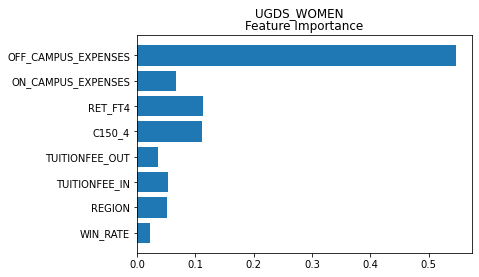

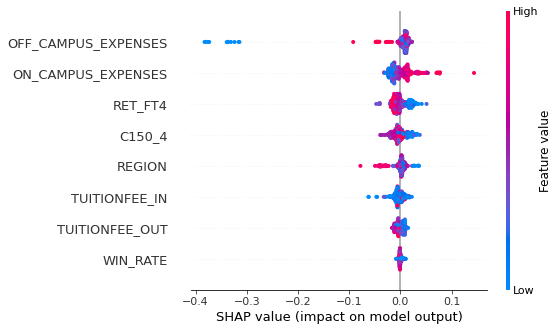

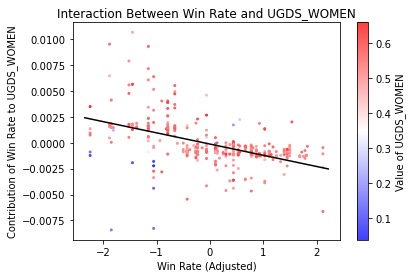

In [190]:
targets = ['ADM_RATE', 'UGDS', 'ACTCMMID', 'SAT_AVG', 'UGDS_WHITE', 'UGDS_BLACK', 'UGDS_HISP', 'UGDS_ASIAN', 'UGDS_MEN', 'UGDS_WOMEN']
demo = ['UGDS_WHITE', 'UGDS_BLACK', 'UGDS_HISP', 'UGDS_ASIAN', 'UGDS_MEN', 'UGDS_WOMEN']
for target in demo:
    feature_importance(target)


In [131]:
def feature_categories(TARGET, TYPE):
    df = pd.read_csv("data_with_uni_type.csv")
    mask = df['University_Type'] == TYPE
    df = df[mask].copy()

    teams = df["TEAM"].unique().tolist()
    # print(teams)
    cols = df.columns.tolist()
    # print(cols)

    targets = ['ADM_RATE', 'UGDS', 'ACTCMMID', 'SAT_AVG', 'UGDS_WHITE', 'UGDS_BLACK', 'UGDS_HISP', 'UGDS_ASIAN', 'UGDS_MEN', 'UGDS_WOMEN']
    y = df[TARGET].values
    df.drop(columns=targets, inplace=True)
    df.drop(columns=['TEAM', 'INSTNM', 'YEAR'], inplace=True)
    df.drop(columns=['WON', 'LOST', 'TIED'], inplace=True)
    df.drop(columns=['University_Type'], inplace=True)
    X = df.values
    cols = df.columns.tolist()

    optimal_model(X, y, TARGET, cols)

Military
UGDS

{'alpha': 1.0, 'eta': 0.1, 'gamma': 1.0, 'lambda': 0.01}
Best MSE: 991792.6006087807
R^2 Score: -12.62228041411167
Most important features:  ['RET_FT4' 'C150_4' 'WIN_RATE']


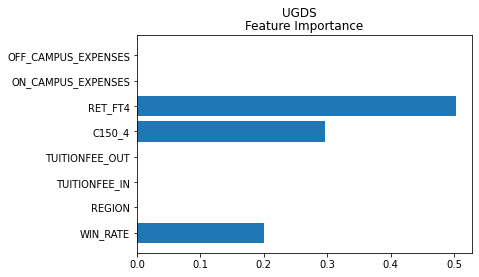

Public
UGDS

{'alpha': 1.0, 'eta': 0.2, 'gamma': 0.01, 'lambda': 1.0}
Best MSE: 15923416.72389191
R^2 Score: 0.8804035266597348
Most important features:  ['RET_FT4' 'TUITIONFEE_IN' 'REGION']


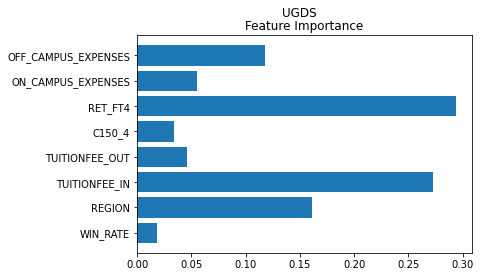

Private
UGDS

{'alpha': 0.01, 'eta': 0.1, 'gamma': 0.01, 'lambda': 1.0}
Best MSE: 2151559.8617309397
R^2 Score: 0.6257982818026959
Most important features:  ['REGION' 'RET_FT4' 'OFF_CAMPUS_EXPENSES']


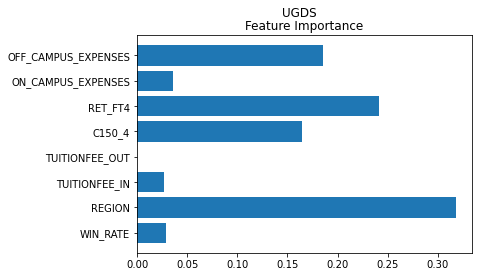

Religious
UGDS

{'alpha': 1.0, 'eta': 0.3, 'gamma': 0.1, 'lambda': 1.0}
Best MSE: 10476377.464803837
R^2 Score: 0.9819700177714474
Most important features:  ['REGION' 'RET_FT4' 'OFF_CAMPUS_EXPENSES']


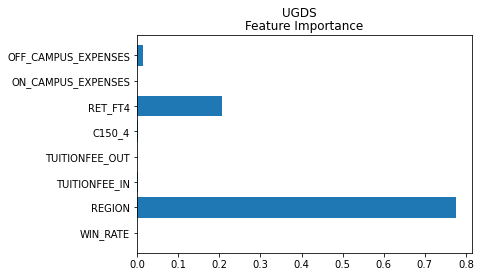

Unknown
UGDS

{'alpha': 1.0, 'eta': 0.4, 'gamma': 1.0, 'lambda': 1.0}
Best MSE: 1860920.3888927586
R^2 Score: 0.8021166103771858
Most important features:  ['TUITIONFEE_IN' 'OFF_CAMPUS_EXPENSES' 'TUITIONFEE_OUT']


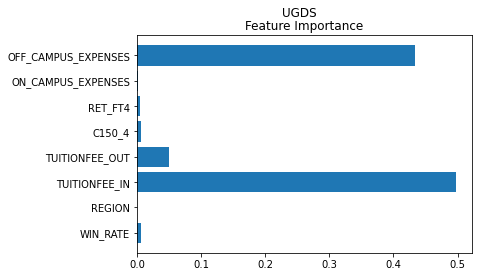

In [132]:
types = ['Military', 'Public', 'Private', 'Religious', 'Unknown']
for type in types:
    print(type)
    feature_categories('UGDS', type)

In [ ]:
df = pd.read_csv("data_with_uni_type.csv")
# df['University_Type'] = df['University_Type'].astype('category').cat.codes
# category_mapping = dict(enumerate(df['University_Type'].cat.categories))
df['University_Type'] = df['University_Type'].astype('category')
df['Type_Codes'] = df['University_Type'].cat.codes

# Get category-to-code mapping
category_mapping = dict(enumerate(df['University_Type'].cat.categories))
print(category_mapping)



{0: 'Military', 1: 'Private', 2: 'Public', 3: 'Religious', 4: 'Unknown'}


In [111]:
df

,TEAM,YEAR,WON,LOST,TIED,WIN_RATE,REGION,ADM_RATE,ACTCMMID,SAT_AVG,...,TUITIONFEE_OUT,C150_4,RET_FT4,UGDS_MEN,UGDS_WOMEN,ON_CAMPUS_EXPENSES,OFF_CAMPUS_EXPENSES,INSTNM,University_Type,Type_Codes
0,Air_Force,2022,3.0,3.0,0.0,0.500000,0.0,0.1623,32.0,1401.0,...,0.0,0.9991,0.9354,0.70550,0.29450,0.0,0.0,United States Air Force Academy,Military,0
1,Air_Force,2021,11.0,2.0,0.0,0.846154,0.0,0.1243,32.0,1382.0,...,0.0,0.8609,0.9253,0.71440,0.28560,0.0,0.0,United States Air Force Academy,Military,0
2,Air_Force,2020,5.0,7.0,0.0,0.416667,0.0,0.1343,31.0,1371.0,...,0.0,0.8732,0.9335,0.71980,0.28020,0.0,0.0,United States Air Force Academy,Military,0
3,Air_Force,2019,5.0,7.0,0.0,0.416667,0.0,0.1108,31.0,1368.0,...,0.0,0.8526,0.9394,0.72420,0.27580,0.0,0.0,United States Air Force Academy,Military,0
4,Air_Force,2018,10.0,3.0,0.0,0.769231,0.0,0.1139,31.0,1366.0,...,0.0,0.8501,0.9527,0.73250,0.26750,0.0,0.0,United States Air Force Academy,Military,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3908,Yale,2002,7.0,3.0,0.0,0.700000,1.0,0.1376,32.0,1465.0,...,27130.0,0.9494,0.9900,0.50170,0.49830,11140.0,11140.0,Yale University,Private,1
3909,Yale,2001,9.0,1.0,0.0,0.900000,1.0,0.1617,32.0,1465.0,...,26100.0,0.9404,0.9900,0.50640,0.49360,11140.0,11140.0,Yale University,Private,1
3910,Yale,2000,6.0,4.0,0.0,0.600000,1.0,0.1617,32.0,1465.0,...,26100.0,0.9459,0.9900,0.50645,0.49355,11140.0,11140.0,Yale University,Private,1
3911,Yale,1999,2.0,8.0,0.0,0.200000,1.0,0.1617,32.0,1465.0,...,26100.0,0.9453,0.9900,0.50650,0.49350,11140.0,11140.0,Yale University,Private,1
